In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import keras
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Import custom functions from other notebooks
sys.path.append("myfun/")
from ipynb.fs.full.myfun_model_linlog import *
from ipynb.fs.full.myfun_model_nn import *
from ipynb.fs.full.myfun_density import *
from ipynb.fs.full.myfun_model_usefulfuns import *

2024-03-08 15:41:06.256318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 15:41:06.256344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 15:41:06.257141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 15:41:06.262812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 15:41:07.290061: W tensorflow/compiler/tf2

# 0. Preliminary

## 0.1 load NN model

In [2]:
dir_nn10 = "2023-12-10_11-38-47_df1-2-3-4-5-6-7-8-9-10_500it-PRE-nn10"

target_dir = "./out/"
namefile_model_nn = "/model_nn10.keras"

In [3]:
# Load NN10 model
dir_nn = dir_nn10
# dir_nn = dir_nn10_v2

path = target_dir + dir_nn
model_nn = keras.models.load_model(path + namefile_model_nn)

## 0.2 Save plot

In [4]:
flag_save = False

In [5]:
# Create the directory..
if flag_save:
    
    ext = ".svg"
    
    # Create directory where to save the image
    now = datetime.now() 
    d = now.strftime(f"%Y-%m-%d_%H-%M-%S_density_log")
    
    path = 'out/' + d
    os.mkdir(path)

# 1. Log discretized density

Tratto da "10.3 Density - traffic models"

In [6]:
## Params
Nx = 400
Nt = 320
T = 0.5

In [7]:
# Space - linearly distributed
dx = 1/int(Nx/3)
a = np.linspace(-1,0,int(Nx/3))
b = np.linspace(0+dx/2, 1, Nx-int(Nx/3))
xspan = np.concatenate([a, b])

# Time
tspan = np.linspace(0,T,Nt)

In [8]:
## LIN BEST
# Params
L_linbest = 0.0025
v0 = 1

# Solve the ODE system in this time interval
sol_linbest = odeint(TD_LWR_model, xspan, tspan, args=(Nx, v0, L_linbest, 'Lin'), tfirst = True).T

# Discretized density
ln = 1/Nx
rho_dis_linbest = ln/np.diff(sol_linbest, axis=0)

## 1.1 Test with different $L$ and $v_0$

In [33]:
Lstart, Lend, Lpoints = dx/4, dx/6, 3
Lrange_log = np.linspace(Lstart, Lend, Lpoints)
v0range_log = [v0 for i in range(len(Lrange_log))]

## Plot params
idx = 0, int(len(tspan)*.5), -1

At t=0.0, MAE=0.0
At t=0.25, MAE=0.0488
At t=0.5, MAE=0.0807


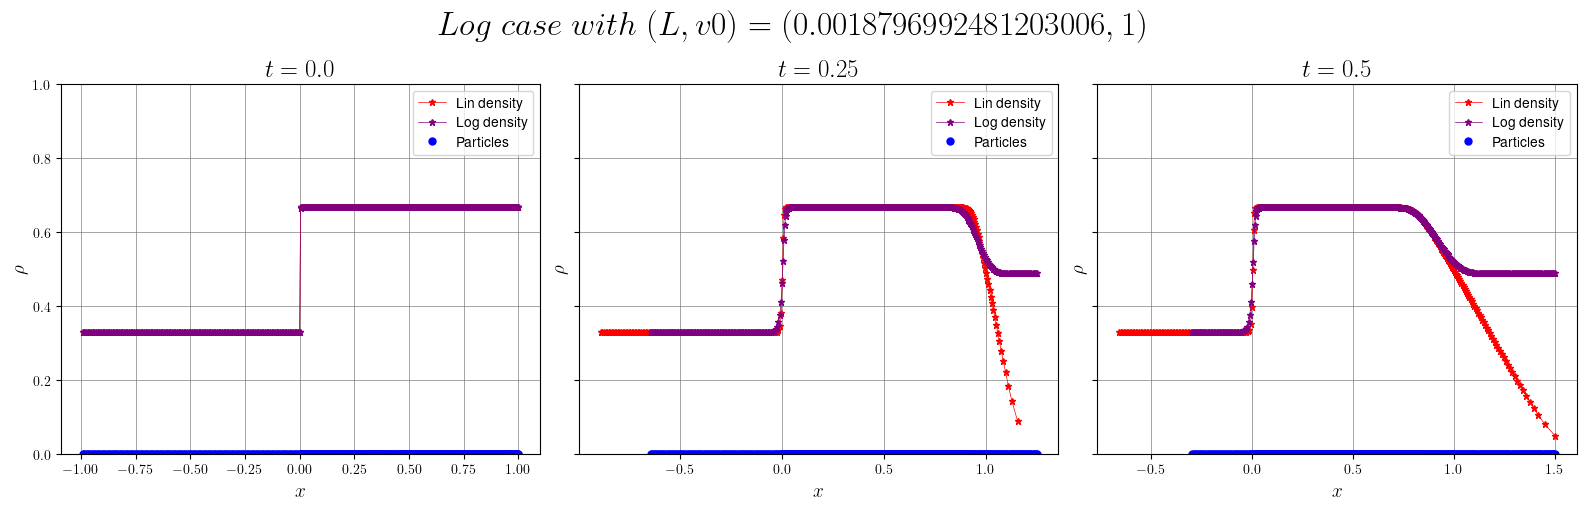

MAE mean value = 0.04318


At t=0.0, MAE=0.0
At t=0.25, MAE=0.0452
At t=0.5, MAE=0.0835


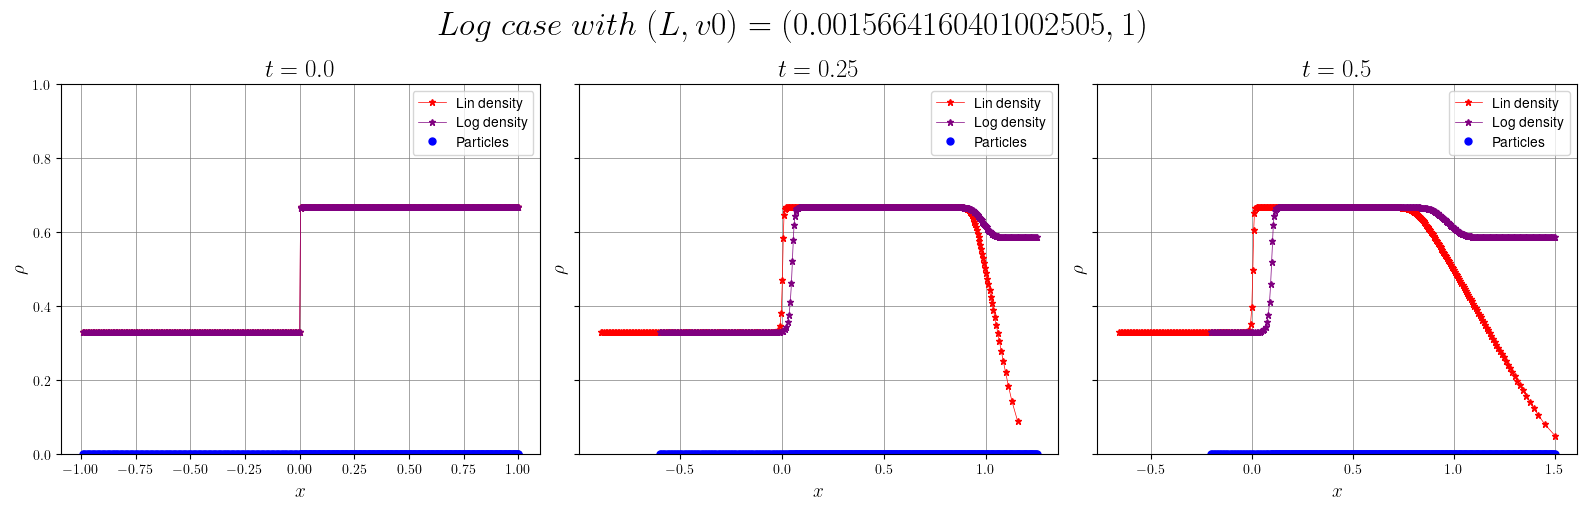

MAE mean value = 0.04292


At t=0.0, MAE=0.0
At t=0.25, MAE=0.0562
At t=0.5, MAE=0.1161


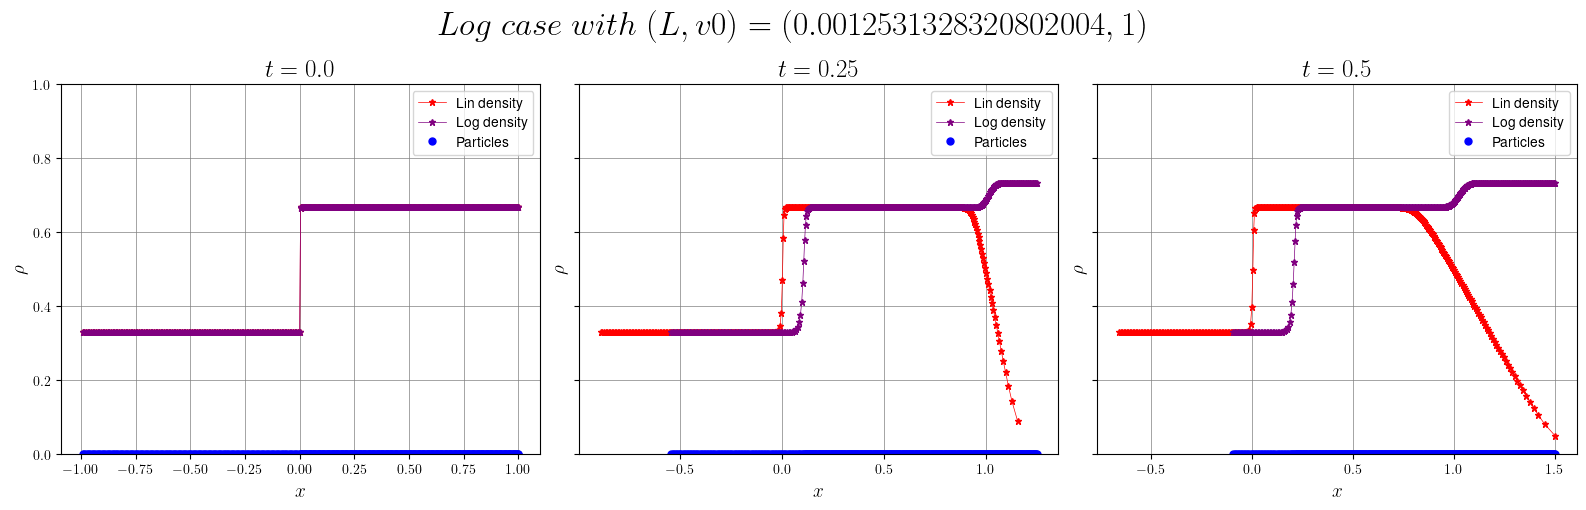

MAE mean value = 0.05744


The min MAE is 0.042922289254408046 and it's reached at 1, so for L=0.0015664160401002505


In [34]:
err_list = []

for L, v0 in zip(Lrange_log, v0range_log):

    # LIN CASE
    sol = odeint(TD_LWR_model, xspan, tspan, args=(Nx, v0, L, 'Log'), tfirst = True).T
    title = fr"$Log\ case\ with\ (L,v0)={L,v0}$"
    
    # Discretized density
    ln = 1/Nx
    rho_dis = ln/np.diff(sol, axis=0)
    
    # Initialize the fig
    nrow, ncol = 1, 3
    width, height = 7, 6

    fig = plt.figure(figsize=(width*ncol*.75,height*nrow*.75), constrained_layout=True)
    plt.suptitle(title, fontsize=24, y=1.1); # Figure titles

    # create 1 x cols subplots per subfig
    axs = fig.subplots(nrows=1, ncols=ncol, sharey = True)

    err_l = []
    
    for col, (ax, i) in enumerate(zip(axs, idx)):

        t = tspan[i]

        # LINEAR
        x_linbest = sol_linbest[:,i][1:]
        ax.plot(x_linbest,rho_dis_linbest[:,i],c='red', ls='-', lw = 0.5, ms=5, marker='*', label="Lin\ density")
#         ax.plot(x_linbest,x_linbest*0,c='blue', ls='', ms=5, marker='o', label="Particles")

        # LOG
        x_log = sol[:,i][1:]
        ax.plot(x_log,rho_dis[:,i],c='purple', ls='-', lw = 0.5, ms=5, marker='*', label="Log\ density")
        ax.plot(x_log,x_log*0,c='blue', ls='', ms=5, marker='o', label="Particles")

        err = mean_absolute_error(y_true = rho_dis_linbest[:,i], y_pred = rho_dis[:,i])
        err_l.append([err, tspan[i],[L,v0]])
        print(fr"At t={t.round(2)}, MAE={err.round(4)}")
        
    #     ax.set_xlim([-1.5,1.5])
        ax.set_ylim([0, 1])
        ax.set_xlabel(r"$x$",fontsize=14)
        ax.set_ylabel(fr"$\rho$",fontsize=14)
        ax.set_title(fr"$t={t.round(3)}$",fontsize=18)

        ax.grid(color='grey', linestyle='-', linewidth=0.5)
        ax.legend()

    plt.show()

        
    tmp = [e[0] for e in err_l]
    print(fr"MAE mean value = {np.mean(tmp).round(5)}")
    print("=="*56)
    print("\n")
    err_list.append(err_l)

    
tmp = [np.mean([e[0] for e in err_l]) for err_l in err_list]
ltmp = [err_l[0][2][0] for err_l in err_list]
mmin = np.min(tmp)
imin = tmp.index(mmin)

print(fr"The min MAE is {mmin} and it's reached at {imin}, so for L={ltmp[imin]}")

## 1.2 Best plot: Log

In [11]:
# Params
L_logbest = .001875

# Solve the ODE system in this time interval
sol_logbest = odeint(TD_LWR_model, xspan, tspan, args=(Nx, v0, L_logbest, 'Log'), tfirst = True).T

# Discretized density
ln = 1/Nx
rho_dis = ln/np.diff(sol_logbest, axis=0)

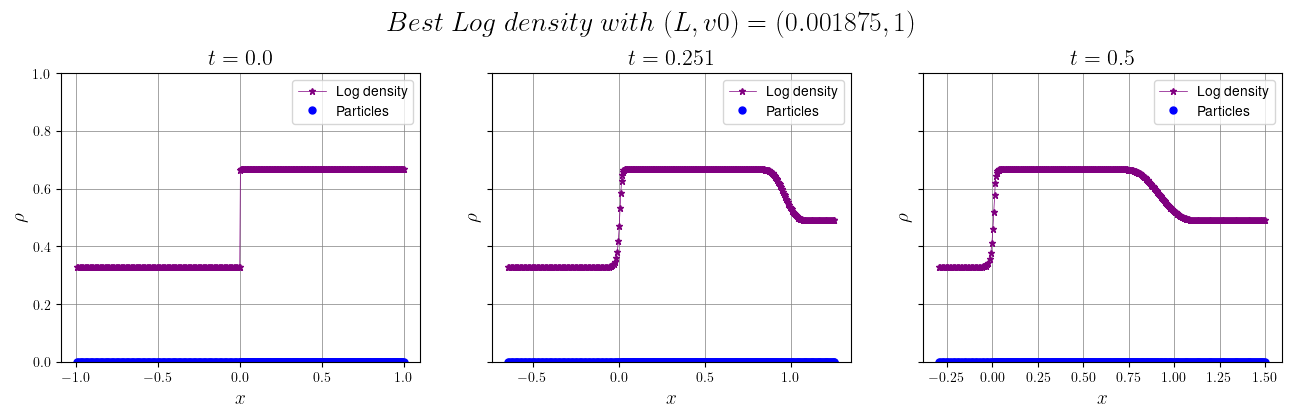

In [12]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5

fig = plt.figure(figsize=(width*ncol*.75,height*nrow*.75))
plt.suptitle(fr"$Best\ Log\ density\ with\ (L,v0)={L_logbest,v0}$", fontsize=20, y = 1.05); # Figure titles

axs = fig.subplots(nrows=1, ncols=ncol, sharey = True)

for col, (ax, i) in enumerate(zip(axs, idx)):

    t = tspan[i]
    x = sol_logbest[:,i][1:]
    ax.plot(x,rho_dis[:,i],c='purple', ls='-', lw = 0.5, ms=5, marker='*', label="Log\ density")
    ax.plot(x,x*0,c='blue', ls='', ms=5, marker='o', label="Particles")

#     ax.set_xlim([-1.5,1.5])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r"$x$",fontsize=14)
    ax.set_ylabel(fr"$\rho$",fontsize=14)
    ax.set_title(fr"$t={t.round(3)}$",fontsize=16)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()

plt.show()

## 1.3 Riemann problem: ovvero l'unico plot che serve

### Preliminary

In [13]:
## Params
Nx = 400
Nt = 201
T = .5

In [14]:
# Space - linearly distributed
dx = 1/int(Nx/3)
a = np.linspace(-1,0,int(Nx/3))
b = np.linspace(0+dx/2, 1, Nx-int(Nx/3))
xspan2 = np.concatenate([a, b])

# Time
tspan = np.linspace(0,T,Nt)
tspan_rounded = list(np.round(tspan,2))

### Simulations

In [15]:
## LINEAR
# Model params
L_lin = .0025
v0 = 1

# Solving the ODE
sol_lin2 = odeint(TD_LWR_model, xspan2, tspan, args=(Nx, v0, L_lin, 'Lin'), tfirst = True).T

# Discretized density
ln = 1/Nx
rho_dis_lin = ln/np.diff(sol_lin2, axis=0)

In [16]:
## NN10
# ODE computation
normalize_flag = True
t_list2, sol_ann_list2, v_list2 = nn_odesolver(model_nn, Nx, xspan2, tspan, normalize_flag)

## Discretized density reconstruction
ln = 1/Nx
rho_dis_ann = ln/np.diff(sol_ann_list2, axis=0)

In [17]:
## LOG
# Model params
L_log = .001875
v0 = 1

# Solving the ODE
sol_log2 = odeint(TD_LWR_model, xspan2, tspan, args=(Nx, v0, L_log, 'Log'), tfirst = True).T

# Discretized density
ln = 1/Nx
rho_dis_log = ln/np.diff(sol_log2, axis=0)

### Plot

In [18]:
# Plot params
fix_flag = True

idx = 0, int(len(tspan)*.5), -1

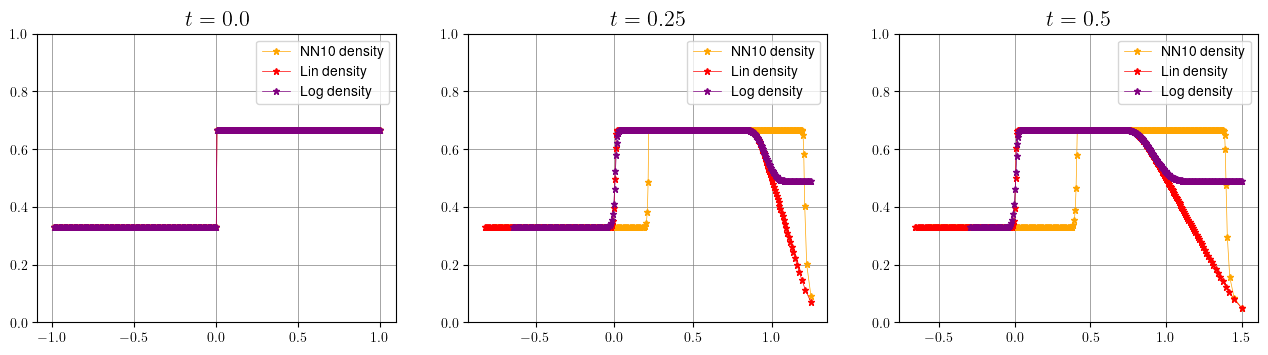

In [19]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# fig.suptitle(fr"$Discretized\ density$", fontsize=20, y = 1.05); # Figure titles

for ax, i in zip(axes, idx):
    
    t = tspan[i]

    # NN10 model
    x_nn = sol_ann_list2[:,i][1:]
    rho_nn = rho_dis_ann[:,i]    
    ax.plot(x_nn, rho_nn, c='orange', ls='-', lw = 0.5, ms=5, marker='*', label="NN10 density")
#     ax.plot(x_nn,x_nn*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    # Linear model
    x_lin = sol_lin2[:,i][1:]
    rho_lin = rho_dis_lin[:,i]
    ax.plot(x_lin, rho_lin ,c='r', ls='-', lw = 0.5, ms=5, marker='*', label="Lin density")
#     ax.plot(x_lin,x_lin*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    # Log model
    x_log = sol_log2[:,i][1:]
    rho_log = rho_dis_log[:,i]
    ax.plot(x_log, rho_log ,c='purple', ls='-', lw = 0.5, ms=5, marker='*', label="Log density")
#     ax.plot(x_log,x_log*0,c='blue', ls='', ms=5, marker='o', label="Particles")


#     ax.set_xlim([-1.25,1.75])
    ax.set_ylim([0, 1])
    ax.set_title(fr"$t={t.round(2)}$",fontsize=16)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()

plt.show()

# Save figure
if flag_save:

    title = f"/nnvslinvslog"     
    fig.savefig(path+title+ext, bbox_inches='tight')

# 2. Velocity vs distances and densities (with LOG)

## Preliminary

In [20]:
# space
N = 100
xspan1 = np.linspace(0.01,1,N) # consecutive distances

# time
Nt = 201
T = .5
tspan1 = np.linspace(0,T,Nt)
dt = T/len(tspan1)

it = -1

## Simulations

### LIN

In [21]:
# Model params
L_lin = L_linbest
v0 = 1

# Solving the ODE
sol_lin1 = odeint(TD_LWR_model, xspan1, tspan1, args=(N, v0, L_lin, 'Lin'), tfirst = True).T

In [22]:
# consecutive distances
xx_lin = np.diff(sol_lin1[:,it],axis=0)

# velocities
dx_sol_lin = []
for car_traj in sol_lin1:
    dx_ct = np.diff(car_traj, axis=0)
    dx_sol_lin.append(dx_ct)

vv_lin = [dx[it]/dt for dx in dx_sol_lin][:-1]

# densities
# dd_lin = 1/xx_lin

In [23]:
## rinormalizzazione
xx_lin = xx_lin/np.max(xx_lin)
vv_lin = vv_lin/np.max(vv_lin)
dd_lin = 1/xx_lin

### LOG

In [24]:
# Model params
L_log = L_logbest
# L_log = L_linbest
v0 = 1

# Solving the ODE
sol_log1 = odeint(TD_LWR_model, xspan1, tspan1, args=(N, v0, L_log, 'Log'), tfirst = True).T

In [25]:
# consecutive distances
xx_log = np.diff(sol_log1[:,it],axis=0)

# velocities
dx_sol_log = []
for car_traj in sol_log1:
    dx_ct = np.diff(car_traj, axis=0)
    dx_sol_log.append(dx_ct)

vv_log = [dx[it]/dt for dx in dx_sol_log][:-1]

In [26]:
## rinormalizzazione
xx_log = xx_log/np.max(xx_log)
vv_log = vv_log/np.max(vv_log)
dd_log = 1/xx_log

### NN10

In [27]:
# ODE computation
t_list, sol_ann_list, v_list = nn_odesolver(model_nn, N, xspan1, tspan1)

In [28]:
# consecutive distances
xx_nn = np.diff(sol_ann_list[:,it],axis=0)

# velocities
## 1. postprocessed
dx_sol_ann = []
for car_traj in sol_ann_list:
    dx_ct = np.diff(car_traj, axis=0)
    dx_sol_ann.append(dx_ct)
vv_nn1 = [dx[it]/dt for dx in dx_sol_ann][:-1]

## 2. preprocessed
vv_nn2 = v_list[:,it][:-1]

vv_nn = vv_nn2

In [29]:
## rinormalizzazione
xx_nn = xx_lin/np.max(xx_nn)
vv_nn = vv_lin/np.max(vv_nn)
dd_nn = 1/xx_nn

## Plot

### 1. LIN

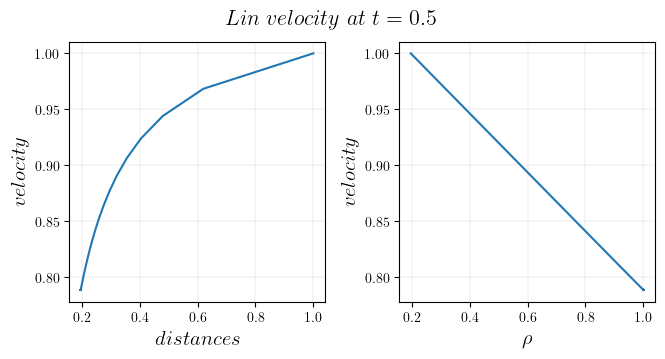

In [30]:
# Initialize the fig
nrow, ncol = 1, 2
width, height = 4.5, 4.5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0
ax[0].plot(xx_lin, vv_lin)

ax[0].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[0].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[0].set_xlabel(fr"$distances$", fontsize=15)
ax[0].set_ylabel(fr"$velocity$", fontsize=15)

# AX 1
dd_lin2 = dd_lin/np.max(dd_lin)

ax[1].plot(dd_lin2, vv_lin)

ax[1].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[1].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[1].set_xlabel(fr"$\rho$", fontsize=15)
ax[1].set_ylabel(fr"$velocity$", fontsize=15)

fig.tight_layout()
plt.suptitle(fr"$Lin\ velocity\ at\ t={tspan1[it]}$", fontsize=16,y=1.05);
plt.show()

# Save figure
if flag_save:

    title = f"/velocity_lin"     
    fig.savefig(path+title+ext, bbox_inches='tight')

### 2. NN

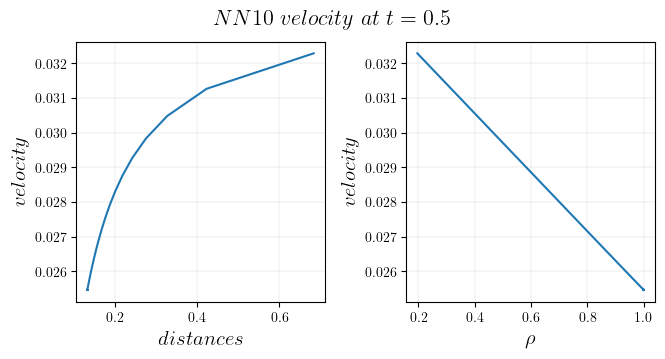

In [31]:
# Initialize the fig
nrow, ncol = 1, 2
width, height = 4.5, 4.5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0
ax[0].plot(xx_nn, vv_nn)

ax[0].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[0].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[0].set_xlabel(fr"$distances$", fontsize=15)
ax[0].set_ylabel(fr"$velocity$", fontsize=15)

# AX 1
dd_nn2 = dd_nn/np.max(dd_nn)
ax[1].plot(dd_nn2, vv_nn)

ax[1].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[1].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[1].set_xlabel(fr"$\rho$", fontsize=15)
ax[1].set_ylabel(fr"$velocity$", fontsize=15)

fig.tight_layout()
plt.suptitle(fr"$NN10\ velocity\ at\ t={tspan1[it]}$", fontsize=16,y=1.05);
plt.show()

# Save figure
if flag_save:

    title = f"/velocity_nn"     
    fig.savefig(path+title+ext, bbox_inches='tight')

### 3. LOG

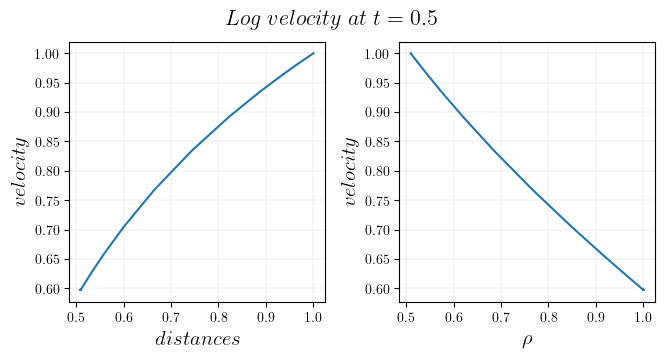

In [32]:
# Initialize the fig
nrow, ncol = 1, 2
width, height = 4.5, 4.5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0
ax[0].plot(xx_log, vv_log)

ax[0].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[0].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[0].set_xlabel(fr"$distances$", fontsize=15)
ax[0].set_ylabel(fr"$velocity$", fontsize=15)

# AX 1
dd_log2 = dd_log/np.max(dd_log)
ax[1].plot(dd_log2, vv_log)

ax[1].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[1].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[1].set_xlabel(fr"$\rho$", fontsize=15)
ax[1].set_ylabel(fr"$velocity$", fontsize=15)

fig.tight_layout()
plt.suptitle(fr"$Log\ velocity\ at\ t={tspan1[it]}$", fontsize=16,y=1.05);
plt.show()

# Save figure
if flag_save:

    title = f"/velocity_log"     
    fig.savefig(path+title+ext, bbox_inches='tight')